## Customer Segmentation using RFM and Clustering (KMeans & DBSCAN)

In this notebook, we apply clustering techniques on **RFM (Recency, Frequency, Monetary)** features derived from the UK-based Online Retail dataset. 

Our goals:
- Segment customers into meaningful groups based on behavior
- Use clustering techniques like **K-Means** and **DBSCAN**
- Evaluate model quality using **Silhouette Score**
- Visualize clusters with **PCA**

This notebook builds upon insights from the EDA notebook, where we identified patterns in customer spending and engagement. Now we aim to group customers to support business strategies such as targeted marketing and loyalty programs.

---



In [39]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

### Data Import & Preprocessing

We'll start by importing the cleaned RFM dataset created in the EDA notebook.


In [70]:
rfm = pd.read_csv('../data/processed/processed_data.csv', encoding='ISO-8859-1')

In [74]:
rfm.set_index('CustomerID', inplace=True)

### Feature Scaling (Standardization)

Since clustering algorithms are distance-based, we apply standardization to ensure all features contribute equally.


In [75]:
# Standardize the RFM values

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency' , 'Frequency', 'Monetary'])

### K-Means Clustering & Elbow Method

We apply the K-Means algorithm to group similar customers. The Elbow Method helps us find the optimal number of clusters.


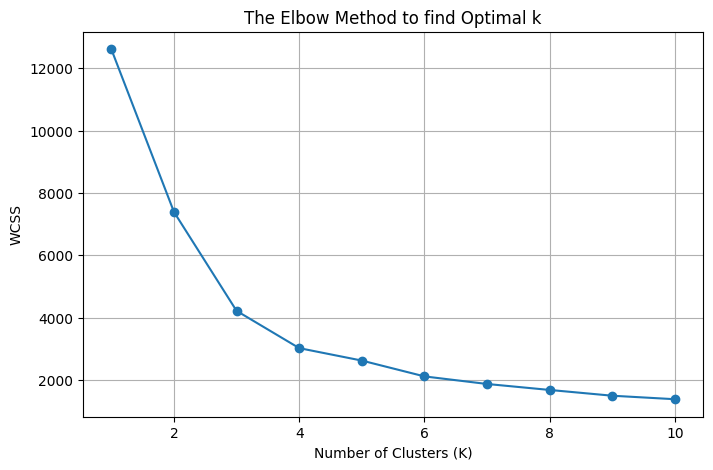

In [76]:
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state= 42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize= (8,5))
plt.plot(K, wcss, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('The Elbow Method to find Optimal k')
plt.grid(True)
plt.show()

In [85]:
# Applying KMeans Cluster for Customer Segmentation
kmeans = KMeans(n_clusters = 3, random_state=42, n_init= 10)
kmeans.fit(rfm_scaled_df)

rfm['Cluster'] = kmeans.labels_

In [117]:
# Save this cluster data 
rfm.to_csv('../data/processed/rfm_clusters.csv')

### Silhouette Score Evaluation

We use the Silhouette Score to measure how well-defined the clusters are.


In [86]:
score = silhouette_score(rfm_scaled_df, rfm['Cluster'])
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.51


###  PCA-Based Cluster Visualization

This 2D plot shows customer segments projected from 3D RFM space. The clear separation of clusters indicates well-defined segments. Overlapping areas may suggest customers with mixed behaviors.


In [97]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data = pca_components, columns = ['PCA1','PCA2'])
pca_df['Cluster'] = kmeans.labels_


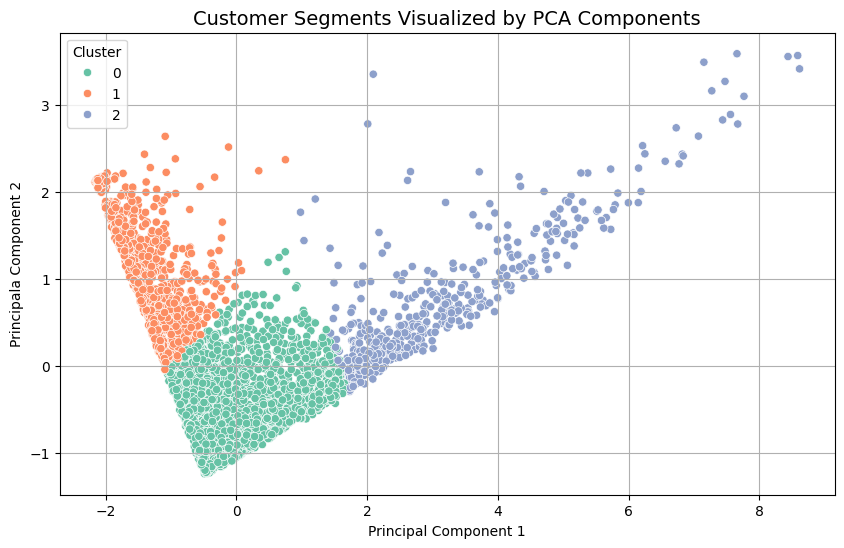

In [96]:
# plotting Scatterplot 
plt.figure(figsize=(10,6))
sns.scatterplot(data = pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Customer Segments Visualized by PCA Components", fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principala Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [108]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns = {'Cluster':'Count'})

display(cluster_summary)

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,45.436143,3.034229,1007.670185,2717
1,240.154440,1.501931,441.872096,1036
2,22.168889,11.753333,5342.571533,450


In [118]:
# Save the Cluster summary 
cluster_summary.to_csv('../data/processed/cluster_summary.csv')

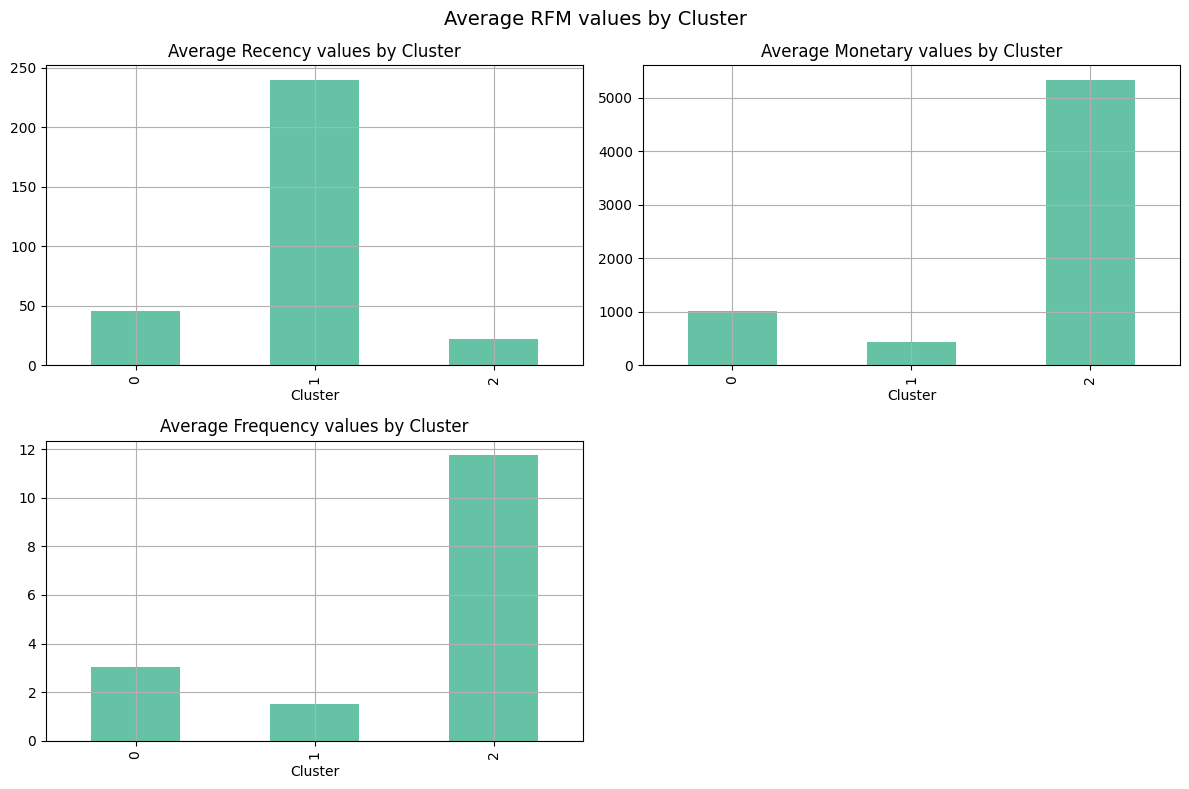

In [129]:
# Bar plot of average RFM values by cluster
cols = ['Recency','Monetary','Frequency']
plt.figure(figsize=(12,8))
for i, col in enumerate(cols, 1):
    plt.subplot(2,2, i)
    rfm.groupby('Cluster')[col].mean().plot(kind='bar',colormap='Set2')
    plt.title(f'Average {col} values by Cluster')
    plt.grid(True)

plt.suptitle("Average RFM values by Cluster", fontsize=14)
plt.tight_layout()
plt.show()


###  Cluster Profiling Summary

- **Cluster 0**: Moderate values - **potentially convertible customers**
- **Cluster 1**: High Recency (i.e., low recent activity) – possibly **inactive or churned customers**.
- **Cluster 2**: High Frequency and Monetary - likely **loyal or high-value customers**.

This profiling enables targeted marketing strategies such as loyalty rewards for Cluster 0 and reactivation campaigns for Cluster 1.


In [89]:
from sklearn.neighbors import NearestNeighbors

# Use Robust Scaled data
X_dbscan = rfm_scaled_df

#Estimate a good eps value using k-distance plot
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

### Choosing the Optimal `eps` for DBSCAN

To apply DBSCAN effectively, we need to determine the ideal `eps` (epsilon) value, which defines the maximum distance between two samples for one to be considered as in the neighborhood of the other.

We use the **k-distance plot** method by:
- Calculating the distance to each point’s *k-th nearest neighbor* (typically `k = min_samples - 1`)
- Sorting these distances and plotting them
- Looking for the **“elbow point”** where the curve sharply changes, indicating a good threshold for density separation

This method helps select an `eps` value that balances cluster detection with noise sensitivity.


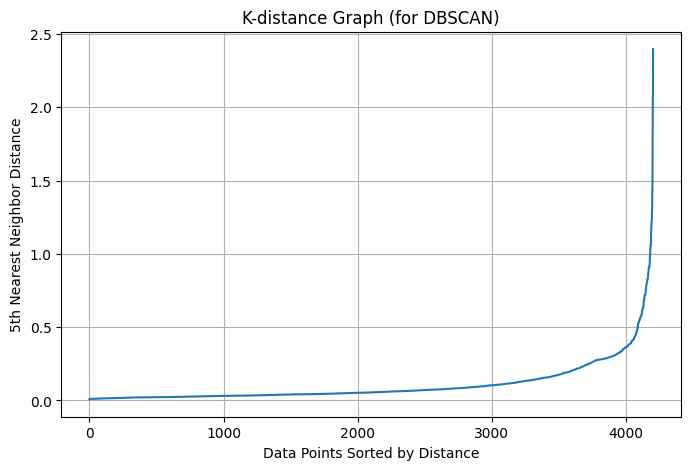

In [90]:
# Sort distances for knee/elbow point
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('K-distance Graph (for DBSCAN)')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid()
plt.show()

### Clustering with DBSCAN (Density-Based Spatial Clustering)

To explore alternative clustering techniques beyond KMeans, we applied DBSCAN — a density-based method effective in detecting noise and arbitrary-shaped clusters.



In [93]:
# Fit DBSCAN
dbscan = DBSCAN(eps= 0.45, min_samples = 5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(X_dbscan)

# Show cluster counts
rfm['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0    4099
-1      91
 1      10
 2       3
Name: count, dtype: int64

- Cluster `-1` indicates noise or outliers detected by DBSCAN.
- Other labels represent detected dense groups.


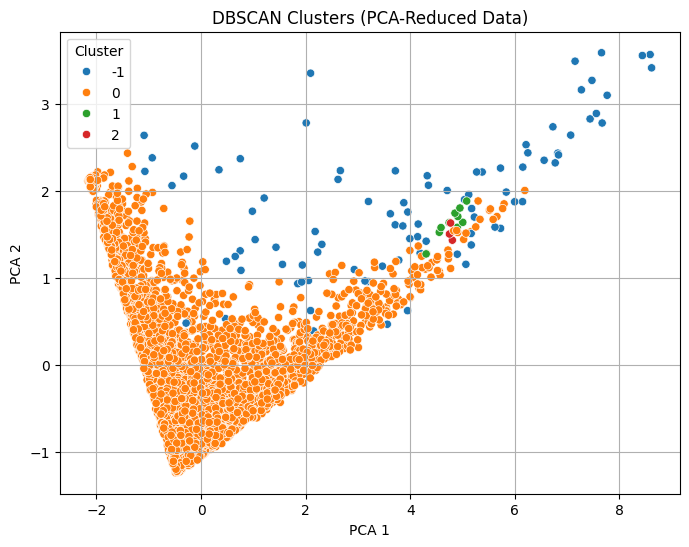

In [94]:
# PCA for 2D visualization
components_dbscan = PCA(n_components = 2).fit_transform(X_dbscan)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components_dbscan[:,0], y= components_dbscan[:,1], hue=rfm['DBSCAN_Cluster'], palette='tab10')
plt.title('DBSCAN Clusters (PCA-Reduced Data)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [110]:
rfm.groupby('DBSCAN_Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'DBSCAN_Cluster':'count'
}).rename(columns={'DBSCAN_Cluster':'Count'})

,Recency,Frequency,Monetary,Count
DBSCAN_Cluster,,,,
-1,78.032967,11.978022,8273.235165,91
0,91.480117,3.374726,1151.684048,4099
1,11.300000,12.200000,10014.607000,10
2,11.666667,14.666667,8671.063333,3


###  DBSCAN Observations:

- DBSCAN detected 3 dense clusters and 91 outlier point.
- Compared to KMeans, it is more robust to noise and non-spherical clusters.
- However, choosing the right `eps` and `min_samples` is critical and may need domain tuning.

In our case, KMeans gave more interpretable and balanced segments, but DBSCAN is valuable for deeper anomaly and density-based segmentation.


In [112]:
dbscan_valid = rfm[rfm['DBSCAN_Cluster'] != 1]
dbscan_score = silhouette_score(rfm_scaled[rfm['DBSCAN_Cluster'] != 1], dbscan_valid['DBSCAN_Cluster'])
print('DBSCAN Silhouette Score (excluding noise):', dbscan_score)

DBSCAN Silhouette Score (excluding noise): 0.5975962220457175


### KMeans vs DBSCAN: Clustering Technique Comparison

In this section, we compare the performance and suitability of KMeans and DBSCAN clustering algorithms on our customer dataset.

| Feature               | KMeans               | DBSCAN                           |
|-----------------------|----------------------|----------------------------------|
| **Number of Clusters**| Predefined (e.g., 3) | Determined by data density       |
| **Noise Handling**    |  Not handled        |  Yes (label `-1` = noise)       |
| **Assumption on Shape**| Spherical clusters   | Arbitrary shapes                 |
| **Parameters**        | `n_clusters`         | `eps`, `min_samples`             |
| **Silhouette Score**  | Interpretable & High | Lower (if many outliers)         |
| **Best Use Case**     | Customer Segments    | Anomaly or dense group detection |

- **KMeans** produced well-separated and interpretable clusters useful for marketing segmentation.
- **DBSCAN** helped detect outliers and captured natural density-based structures in data.

>  We found that **KMeans** works best for our business objective of **customer segmentation**, while DBSCAN provides an additional layer for **outlier and noise detection**.


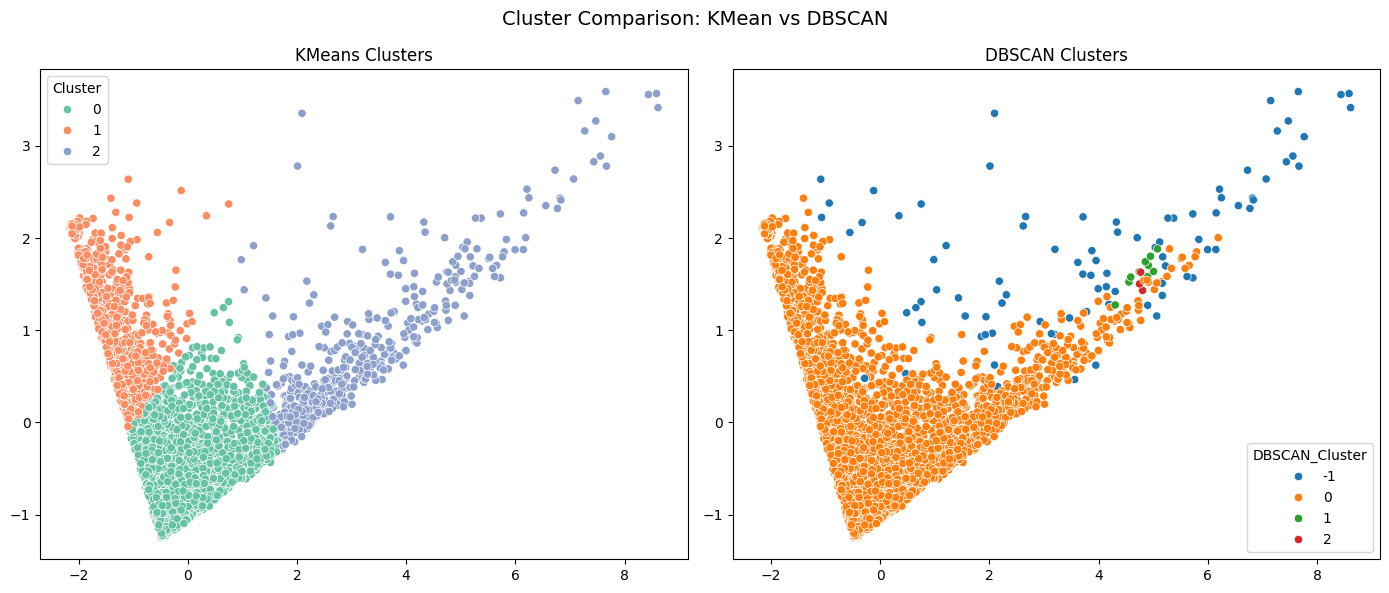

In [98]:
# Comparison plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=pca_data[:,0], y=pca_data[: ,1], hue = rfm['Cluster'], ax = ax[0], palette='Set2')
ax[0].set_title('KMeans Clusters')

sns.scatterplot(x=components_dbscan[:, 0], y= components_dbscan[:,1], hue= rfm['DBSCAN_Cluster'], ax= ax[1], palette ='tab10')
ax[1].set_title('DBSCAN Clusters')

plt.suptitle('Cluster Comparison: KMean vs DBSCAN', fontsize=14)
plt.tight_layout()
plt.show()

## Final Summary & Business Recommendations

###  Project Recap
In this project, we performed **customer segmentation** using RFM (Recency, Frequency, Monetary) analysis and applied **unsupervised clustering techniques (KMeans and DBSCAN)** to identify distinct customer groups. Our goal was to provide actionable insights for targeted marketing and personalized business strategies.

###  Key Findings
- **RFM Segmentation** revealed natural variance in customer behaviors, ideal for clustering.
- **KMeans Clustering** (with k=3) produced:
  - Clear, well-separated customer segments
  - Interpretable profiles suitable for marketing
- **DBSCAN Clustering** helped detect **anomalous customers or noise**, adding robustness to our analysis.

###  Business Recommendations
Based on the clustering analysis:
1. **High-Value Cluster**:
   - Customers with **low recency**, **high frequency**, and **high monetary value**
   -  **Action**: Launch loyalty programs, exclusive offers, and VIP services.

2. **Churn-Risk Cluster**:
   - Customers with **high recency** and **low frequency**
   -  **Action**: Re-engagement campaigns, win-back discounts.

3. **Low-Engagement Cluster**:
   - Infrequent and low-spending customers
   -  **Action**: Educate on value propositions, cross-sell strategies.

4. **Outliers (from DBSCAN)**:
   - Unusual behavior — possibly **one-time bulk buyers** or **fraudulent** activity
   -  **Action**: Manual review or anomaly flagging.

###  Final Takeaway
KMeans is best suited for **interpretable customer segmentation**, while DBSCAN adds depth by detecting **noise and outliers**. Together, these techniques provide a **holistic customer view** to drive data-informed business decisions.
